# Setup

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
!ls going_modular/going_modular

data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Getting Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# FoodVision Mini model deployment experiment outline

# Creating an EffNetB2 feature extractor

In [ ]:
import torchvision

# Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 82.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# set seeds
set_seeds()

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

In [ ]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model , transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3,
                                                      seed = 42)

In [ ]:
summary(effnetb2,
        input_size = (1,3,288,288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

## Creating DataLoaders for EffNetB2

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = effnetb2_transforms,
                                                                              batch_size = 32)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# define loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = effnetb2.parameters(), lr = 1e-3)

# training function
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5708 | test_loss: 0.7390 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6835 | train_acc: 0.8771 | test_loss: 0.5929 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5640 | train_acc: 0.8958 | test_loss: 0.4816 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4716 | train_acc: 0.8729 | test_loss: 0.4183 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.4308 | train_acc: 0.8729 | test_loss: 0.3723 | test_acc: 0.9659
Epoch: 6 | train_loss: 0.3738 | train_acc: 0.8979 | test_loss: 0.3456 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3373 | train_acc: 0.9062 | test_loss: 0.3132 | test_acc: 0.9568
Epoch: 8 | train_loss: 0.3248 | train_acc: 0.9250 | test_loss: 0.3009 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3671 | train_acc: 0.8562 | test_loss: 0.2747 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2564 | train_acc: 0.9458 | test_loss: 0.2649 | test_acc: 0.9597


## Inspecting EffNetB2 loss curves

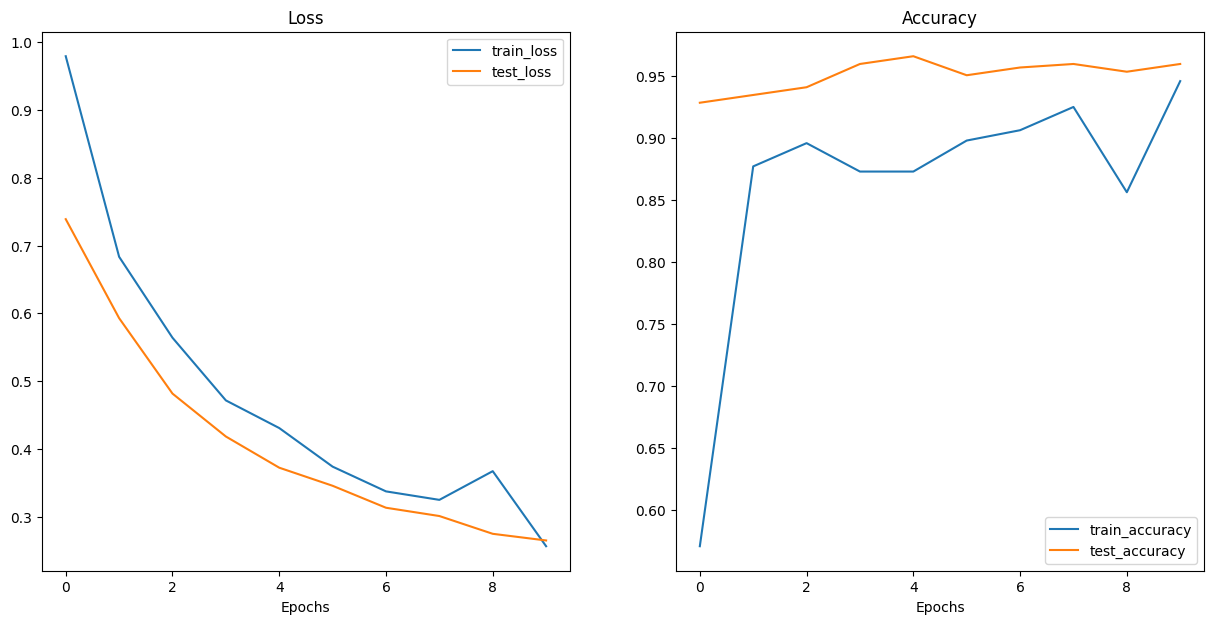

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


## Inspecting the size of our EffNetB2 feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


## Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
effnetb2_results

{'train_loss': [0.979401167233785,
  0.6834686994552612,
  0.5640306234359741,
  0.47155195474624634,
  0.43076655467351277,
  0.37381431460380554,
  0.3373116314411163,
  0.32480193972587584,
  0.3671445846557617,
  0.25639975666999815],
 'train_acc': [0.5708333333333333,
  0.8770833333333333,
  0.8958333333333334,
  0.8729166666666667,
  0.8729166666666667,
  0.8979166666666667,
  0.90625,
  0.925,
  0.85625,
  0.9458333333333333],
 'test_loss': [0.73897305727005,
  0.5929279088973999,
  0.48160143494606017,
  0.41828819513320925,
  0.3722662031650543,
  0.3455898106098175,
  0.31317943036556245,
  0.30094956755638125,
  0.2747133314609528,
  0.26490041613578796],
 'test_acc': [0.928409090909091,
  0.934659090909091,
  0.940909090909091,
  0.959659090909091,
  0.965909090909091,
  0.9505681818181818,
  0.9568181818181818,
  0.959659090909091,
  0.953409090909091,
  0.959659090909091]}

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.26490041613578796,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285}

# Creating a ViT feature extractor

In [ ]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # create ViT_B_16 pretrained weights
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)

  model.heads = nn.Sequential(
      nn.Linear(in_features = 768, out_features = num_classes)
  )

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()

vit, vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 90.7MB/s]


(VisionTransformer(
   (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
   (encoder): Encoder(
     (dropout): Dropout(p=0.0, inplace=False)
     (layers): Sequential(
       (encoder_layer_0): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (self_attention): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         )
         (dropout): Dropout(p=0.0, inplace=False)
         (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (0): Linear(in_features=768, out_features=3072, bias=True)
           (1): GELU(approximate='none')
           (2): Dropout(p=0.0, inplace=False)
           (3): Linear(in_features=3072, out_features=768, bias=True)
           (4): Dropout(p=0.0, inplace=False)
         )
       )
       (encoder_layer_1): EncoderBlock(
         (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine

In [ ]:
summary(vit,
        input_size = (1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Create DataLoaders for ViT feature extractor

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## Training ViT Feature Extractor

In [ ]:
from going_modular.going_modular import engine

# setup optimizer
optimizer = torch.optim.Adam(params = vit.parameters(), lr = 1e-3)

# setup loss_fn
loss_fn = nn.CrossEntropyLoss()

# set seed
set_seeds()

vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## Plot loss curves of ViT feature extractor

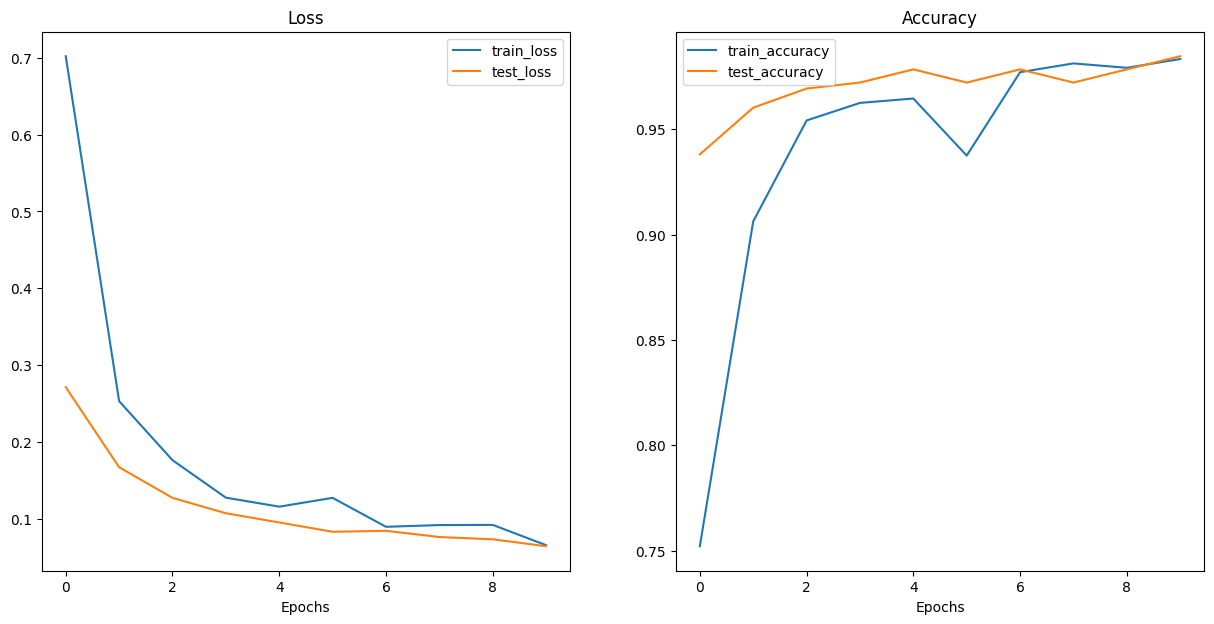

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving ViT feature extractor

In [ ]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


## Checking the size of ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327.3689556121826 MB


## Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

In [ ]:
vit_stats

{'test_loss': 0.06443446669727564,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3689556121826}

## Making predictions with our trained models and timing them

In [ ]:
from pathlib import Path

# Get all test data path
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/420409.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg')]

## Creating a function to make across the test dataset

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict, Tuple

def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # create an empty list
  pred_list = []

  # loop through the target input paths
  for path in tqdm(paths):
    # create an empty dictionary for each sample
    pred_dict = {}

    # get the sample path and ground truth class from the filepath
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # start the prediction timer
    start_time = timer()

    # open the image using PIL Image.open()
    img = Image.open(path)

    # transform the image
    transformed_image = transform(img).unsqueeze(0).to(device)

    # prepare the model in inference mode
    model = model.to(device)
    model.eval()

    # inference mode
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim = 1)
      pred_label = torch.argmax(pred_prob, dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # end the prediction timer
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

      # See if the predicted class matches the ground truth class.
      pred_dict["correct"] = class_name == pred_class

      # Append the updated prediction dictionary to the empty list of predictions we created in step 2.
      pred_list.append(pred_dict)

  # Return the list of prediction dictionaries.
  return pred_list

## Making and timing predictions with EffNetB2

In [ ]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7067,
  'pred_class': 'pizza',
  'time_for_pred': 0.3016,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6354,
  'pred_class': 'pizza',
  'time_for_pred': 0.2046,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.7067,pizza,0.3016,True
1,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.6354,pizza,0.2046,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9439,pizza,0.2136,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.8485,pizza,0.2103,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.7431,pizza,0.1574,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1656


In [ ]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.26490041613578796,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285,
 'time_per_pred_cpu': 0.1656}

## Making and timing predictions with ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9984,
  'pred_class': 'pizza',
  'time_for_pred': 1.0864,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9855,
  'pred_class': 'pizza',
  'time_for_pred': 0.6506,
  'correct': True}]

In [ ]:
# turn vits result dict to DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.9984,pizza,1.0864,True
1,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9855,pizza,0.6506,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9980,pizza,0.7053,True
3,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9989,pizza,0.6671,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9984,pizza,0.6710,True


In [ ]:
# See how many correct
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.782


In [ ]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443446669727564,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3689556121826,
 'time_per_pred_cpu': 0.782}

# Comparing model results, prediction times and size

In [ ]:
# Turn stats into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# add column for model names
df['model'] = ['EffNetB2', "ViT"]

# convert accuracy to percentages
df['test_acc'] = round(df['test_acc']*100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.264900,95.97,7705221,29.857111,0.1656,EffNetB2
1,0.064434,98.47,85800963,327.368956,0.7820,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.24324,1.02605,11.135432,10.964522,4.722222


## Visualizing the speed vs. performance tradeoff

In [ ]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.264900,95.97,7705221,29.857111,0.1656,EffNetB2
1,0.064434,98.47,85800963,327.368956,0.7820,ViT


In [ ]:
import matplotlib

matplotlib.__version__

'3.8.0'

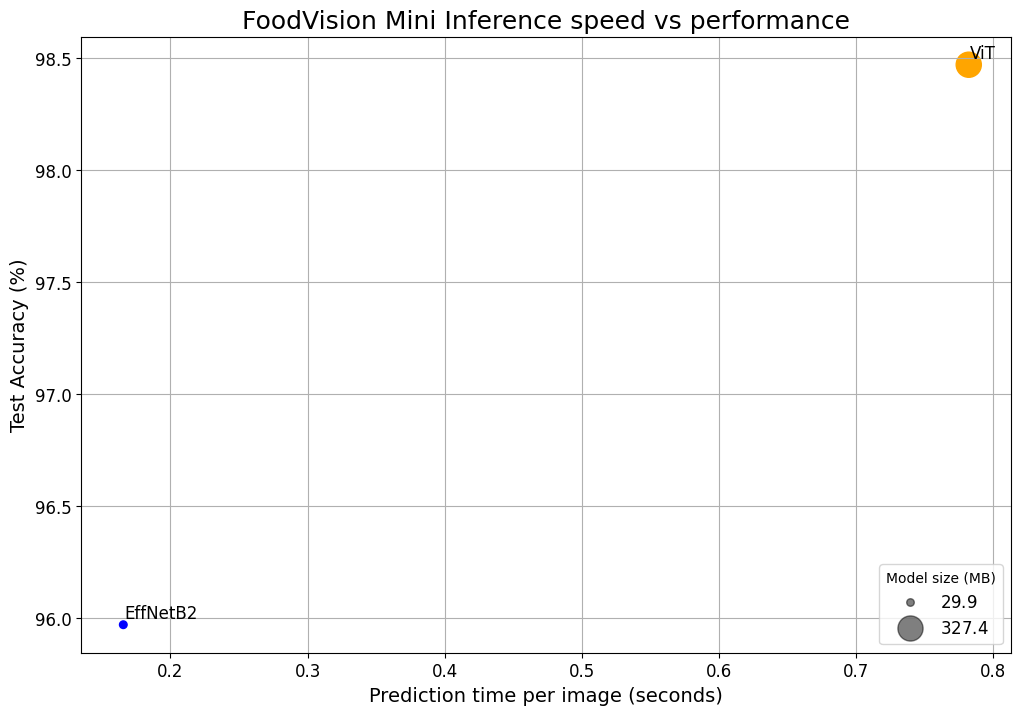

In [ ]:
import matplotlib.pyplot as plt

# Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data = df,
                     x = "time_per_pred_cpu",
                     y = "test_acc",
                     c = ['blue', "orange"],
                     s = "model_size (MB)",)

# Add titles and labels to make plot good
ax.set_title("FoodVision Mini Inference speed vs performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis = "both", labelsize = 12)
ax.grid(True)

# Annoatte the samples on the scatter plot
for index, row in df.iterrows():
  ax.annotate(text = row['model'],
              xy = (row['time_per_pred_cpu'] + 0.0006, row['test_acc'] + 0.03),
              size = 12)

# create a legend based on the model sizes
handles, labels = scatter.legend_elements(prop="sizes",alpha = 0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = 'lower right',
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

# Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 9.8 MB/s eta 0:00:00
Gradio version: 5.8.0


## Creating a function to map our inputs and outputs

In [ ]:
# put model on the cpu
effnetb2 = effnetb2.to("cpu")

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg

{'pizza': 0.021667638793587685, 'steak': 0.828117847442627, 'sushi': 0.1502145379781723}
0.1599


## Creating a list of example images

In [ ]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg']]

## Building a Gradio Interface

In [ ]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# create the gradio demo
demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type="pil"),
                    outputs = [gr.Label(num_top_classes = 3, label="Predictions"),
                               gr.Number(label = "Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article
                    )

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5f0d76e063fe024722.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Turning our FoodVision Mini Gradio Demo into a deployable app

## Creating a `demos` folder to store our FoodVision app files

In [ ]:
import shutil
from pathlib import Path

# create Foodvision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

## Creating a folder of example images to use with our FoodVision Mini demo

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

## Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# move the model to file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
  shutil.move(src = effnetb2_foodvision_mini_model_path,
              dst = effnetb2_foodvision_mini_model_destination)
  print("[INFO] Model successfully moved!")
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model successfully moved!


## Turning off EffNetB2 model into a Python script `(model.py)`

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
class_names

['pizza', 'steak', 'sushi']

## Turning our FoodVision Mini Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# setup class names
class_names = ['pizza', 'steak', 'sushi']

# Model and transforms preperation
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = 3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

# predict function
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

# gradio app

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


## Creating a requirements file for FoodVision Mini (requirements.txt)

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


# Deploying our FoodVision Mini app HuggingFace Spaces

## Downloading our FoodVision Mini app files

In [ ]:
!ls demos/foodvision_mini/examples

2582289.jpg  3622237.jpg  592799.jpg


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Running our Gradio demo app locally

## Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini_video/+", width=900, height=750)

# Creating FoodVision Big!!!

## Creating a model for FoodVision Big + transforms

In [ ]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Create training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Getting data for FoodVision Big

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 images x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # apply data augmentation to training data
                              download=True)

# Get the testing data (~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 5.00G/5.00G [03:14<00:00, 25.6MB/s]


Extracting data/food-101.tar.gz to data


In [ ]:
750 * 101, 250 * 101

(75750, 25250)

In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Creating a subset of the Food101 dataset for faster experimenting

In [ ]:
len(train_data) * 0.2, len(test_data) * 0.2

(15150.0, 5050.0)

In [ ]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # defaults to 20% data split
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [ ]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [ ]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

## Turning our Food101 datasets into `DataLoaders`

In [ ]:
import os

os.cpu_count()

2

In [ ]:
import os
import torch

NUM_WORKERS = 2 # this value is very experimental and the best value will differ depeneding on the hardware you're using, search "pytorch num workers setting for more"
BATCH_SIZE = 32

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

## Training FoodVision Big!!!!

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6409 | train_acc: 0.2770 | test_loss: 2.7822 | test_acc: 0.4898


## Inspecting loss curves of FoodVision Big model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

## Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

## Checking FoodVision Big model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

# Turning our FoodVision Big model into a deployable app

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [ ]:
!ls demos/foodvision_big/

## Downloading an example image and moving it to the examples directory

In [ ]:
# Download and move example image
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big/

## Saving Food101 class names to file (`class_names.txt`)

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

In [ ]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # new line per class name

In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:5]

## Turning our FoodVision Big model into a Python script (`model.py`)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

## Turning our FoodVision Big Gradio app into a Python script (`app.py`)

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location=torch.device("cpu")) # load to CPU
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision BIG 🍔👁💪"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

## Creating a requirements file for FoodVision Big (`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch
torchvision
gradio

## Downloading our FoodVision Big app files

In [ ]:
# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

In [ ]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.")

## Deploying our FoodVision Big model app to Hugging Faces Spaces